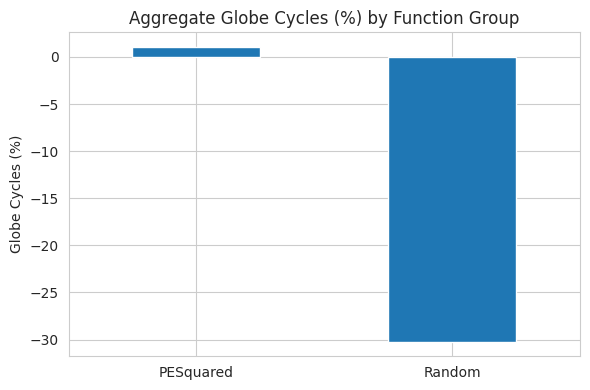

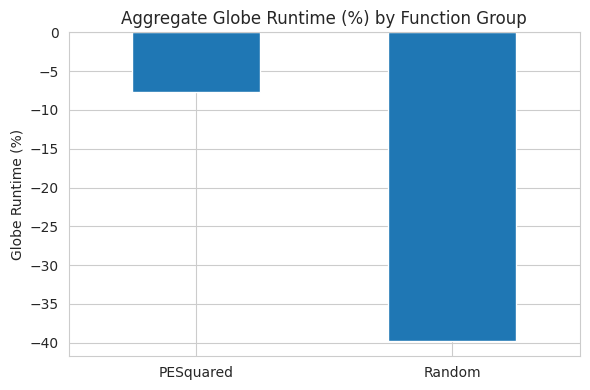

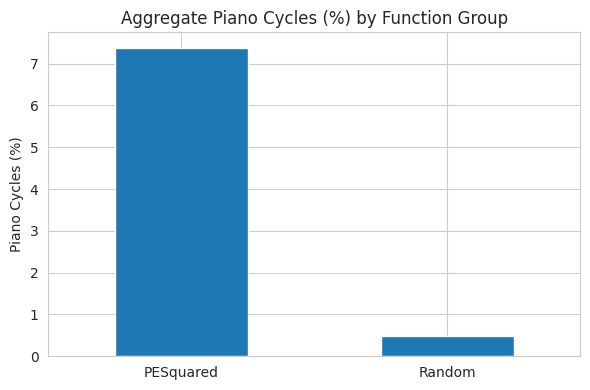

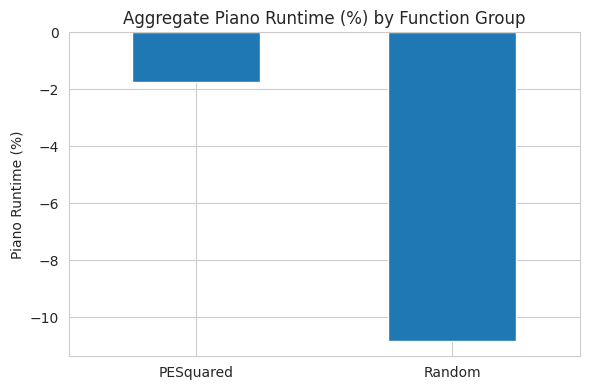

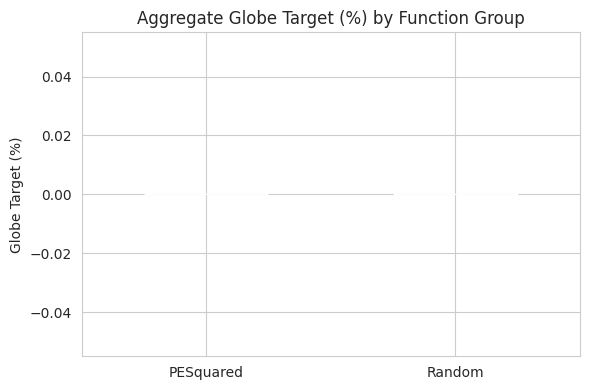

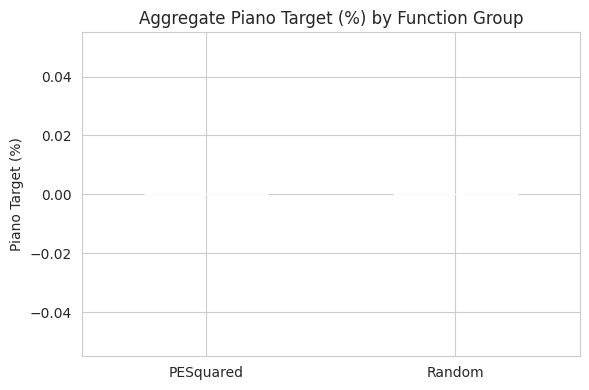

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Configuration ---
CSV_PATH = 'optimization_results.csv'  # path to your CSV
PLOTS_DIR = 'plots'
os.makedirs(PLOTS_DIR, exist_ok=True)

# Baseline measurements (ignore the ones in the CSV)
baselines = {
    'globe': {
        'task-clock': 1626.394311,
        'cycles': 8059846018.0,
        'target_fns': {
            'Sphere::getIntersection': 21200000,
            'Ray::Ray': 6800000,
            '_int_free': 6000000,
            'cfree@GLIBC_2.2.5': -1,
            'Vector::operator*': 2400000,
            'Vector::mag2': 8400000,
            'Plane::getIntersection': 10600000,
            'refresh': -1,
            'solveScalers': 14200000,
            'Vector::operator-': 5400000,
            'fix': 64800000,
            'Box::getIntersection': -1,
            'Vector::dot': 27000000,
            'getLight': 37200000,
            'calcColor': 36200000
        }
    },
    'pianoroom': {
        'task-clock': 578.989076,
        'cycles': 2891368942.0,
        'target_fns': {
            'Sphere::getIntersection': 1800000,
            'Ray::Ray': 5400000,
            '_int_free': 8000000,
            'cfree@GLIBC_2.2.5': -1,
            'Vector::operator*': 3200000,
            'Vector::mag2': 800000,
            'Plane::getIntersection': 39800000,
            'refresh': -1,
            'solveScalers': 114800000,
            'Vector::operator-': 18000000,
            'fix': 5800000,
            'Box::getIntersection': 50200000,
            'Vector::dot': 47000000,
            'getLight': 58600000,
            'calcColor': 21800000
        }
    }
}

# --- Load data ---
df = pd.read_csv(CSV_PATH)

# --- Recompute improvements relative to baselines ---
df['globe_cycles_impr']   = (baselines['globe']['cycles']   - df['globe_cycles'])   / baselines['globe']['cycles']   * 100
df['globe_runtime_impr']  = (baselines['globe']['task-clock'] - df['globe_runtime'])  / baselines['globe']['task-clock'] * 100
df['piano_cycles_impr']   = (baselines['pianoroom']['cycles'] - df['pianoroom_cycles']) / baselines['pianoroom']['cycles'] * 100
df['piano_runtime_impr']  = (baselines['pianoroom']['task-clock'] - df['pianoroom_runtime'])/ baselines['pianoroom']['task-clock'] * 100

def target_improvement(row, key):
    b = baselines[key]['target_fns'].get(row['function'], -1)
    if b <= 0:
        return np.nan
    return (b - row[f'{key}_cycles_target_function']) / b * 100

df['globe_target_impr']  = df.apply(lambda r: target_improvement(r, 'globe'),  axis=1)
df['piano_target_impr']  = df.apply(lambda r: target_improvement(r, 'pianoroom'), axis=1)

# --- Identify first/last three unique functions ---
unique_funcs = df['function'].unique()
first_three = unique_funcs[:3]
last_three  = unique_funcs[-3:]

groups = {
    'first_three': first_three,
    'last_three':  last_three
}

# --- Aggregate (mean) improvements for each group ---
metrics = {
    'Globe Cycles (%)':   'globe_cycles_impr',
    'Globe Runtime (%)':  'globe_runtime_impr',
    'Piano Cycles (%)':   'piano_cycles_impr',
    'Piano Runtime (%)':  'piano_runtime_impr',
    'Globe Target (%)':   'globe_target_impr',
    'Piano Target (%)':   'piano_target_impr',
}

agg = pd.DataFrame({
    name: {
        label: df.loc[df['function'].isin(funcs), col].mean()
        for label, col in metrics.items()
    }
    for name, funcs in groups.items()
}).T

# --- Plot ---
for metric_label in agg.columns:
    plt.figure(figsize=(6, 4))
    ax = agg[metric_label].plot(kind='bar', rot=0)
    ax.set_title(f'Aggregate {metric_label} by Function Group')
    ax.set_ylabel(metric_label)
    ax.set_xticklabels(['PESquared', 'Random'])
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, f'agg_{metric_label.replace(" ", "_")}.pdf'))
    plt.show()
